##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

C:\Users\Lin Ziyu\AppData\Local\Temp\ipykernel_20492\762827891.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [ ]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv" 
df2 = pd.read_csv(filepath)
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [ ]:
##Data Cleaning

#Find data which empty value are likely due to mistakes
df2.isna().sum()

LATITUDE                                 120
LONGITUDE                                120
AccountID                                  0
Company                                    0
SIC Code                                   0
Industry                                   0
8-Digit SIC Code                           0
8-Digit SIC Description                    0
Year Found                               434
Entity Type                                0
Parent Company                           514
Parent Country                           520
Ownership Type                             0
Company Description                        0
Square Footage                         29182
Company Status (Active/Inactive)           0
Employees (Single Site)                12403
Employees (Domestic Ultimate Total)       79
Employees (Global Ultimate Total)       2774
Sales (Domestic Ultimate Total USD)        0
Sales (Global Ultimate Total USD)          0
Import/Export Status                   22569
Fiscal Yea

In [ ]:
#Remove companies with null values
df2 = df2.dropna(subset=["LATITUDE", "LONGITUDE"])
df2['Import/Export Status_Missing'] = df2['Import/Export Status'].isna()
df3 = df2.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)", "Year Found"])

#One-hot encoding of important classification
df3 = pd.get_dummies(df2, columns=['Entity Type'], prefix='Entity_Type')
df3 = pd.get_dummies(df2, columns=['Ownership Type'], prefix='Ownership_Type')
df3 = pd.get_dummies(df2, columns=['Import/Export Status'], prefix='Import_Export_Status')

#Remove irrelevant information
df3 = df2.drop(columns=[col for col in ["AccountID", "Industry", "8-Digit SIC Code", "8-Digit SIC Description", "Company Description", "Company Status (Active/Inactive)", "Entity Type", "Square Footage", "Fiscal Year End", 'Import/Export Status', 'Ownership Type'] if col in df2.columns], errors='ignore') # are all Active

#Convert rare instances of SIC code into 'others'
sic_code_frequency = df3['SIC Code'].value_counts()
threshold = 7
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index
df3['SIC Code'] = df3['SIC Code'].replace(low_frequency_sic_codes, 'Others')
sic_code_frequency1 = df3['SIC Code'].value_counts()
df3['SIC Code'] = df3['SIC Code'].astype(str)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df3['SIC Code'] = label_encoder.fit_transform(df3['SIC Code'])

#Check the information that is left
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29062 entries, 0 to 29181
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   LATITUDE                             29062 non-null  float64
 1   LONGITUDE                            29062 non-null  float64
 2   Company                              29062 non-null  object 
 3   SIC Code                             29062 non-null  int32  
 4   Year Found                           28632 non-null  float64
 5   Parent Company                       28552 non-null  object 
 6   Parent Country                       28546 non-null  object 
 7   Employees (Single Site)              16705 non-null  float64
 8   Employees (Domestic Ultimate Total)  28984 non-null  float64
 9   Employees (Global Ultimate Total)    26296 non-null  float64
 10  Sales (Domestic Ultimate Total USD)  29062 non-null  float64
 11  Sales (Global Ultimate Total USD)

In [ ]:
#Visualizations of the Data/Clustering

#Basic settings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
norm = LogNorm()
cmap = 'plasma'

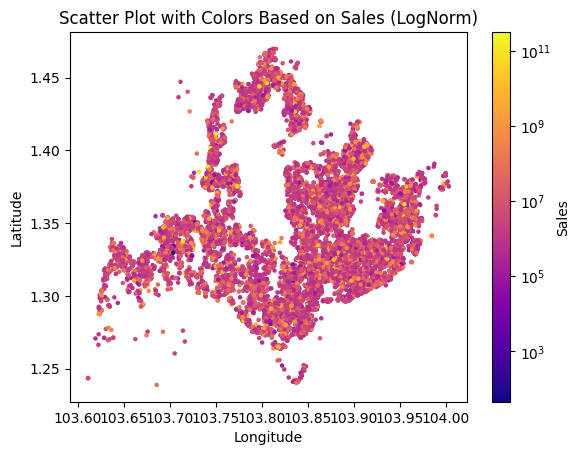

In [ ]:
#Scatter plot of geographical income
scatter = plt.scatter(df3['LONGITUDE'], df3['LATITUDE'], c=df3['Sales (Domestic Ultimate Total USD)'], cmap=cmap, s=5, norm=norm)
cbar = plt.colorbar(scatter, label='Sales')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Colors Based on Sales (LogNorm)')

plt.show()

In [ ]:
#Find the most predominant SIC codes
print(sic_code_frequency1)

SIC Code
6719.0    7743
8742.0    1387
Others     883
7371.0     774
4731.0     734
          ... 
781.0        7
2035.0       7
7313.0       7
3442.0       7
5441.0       7
Name: count, Length: 330, dtype: int64


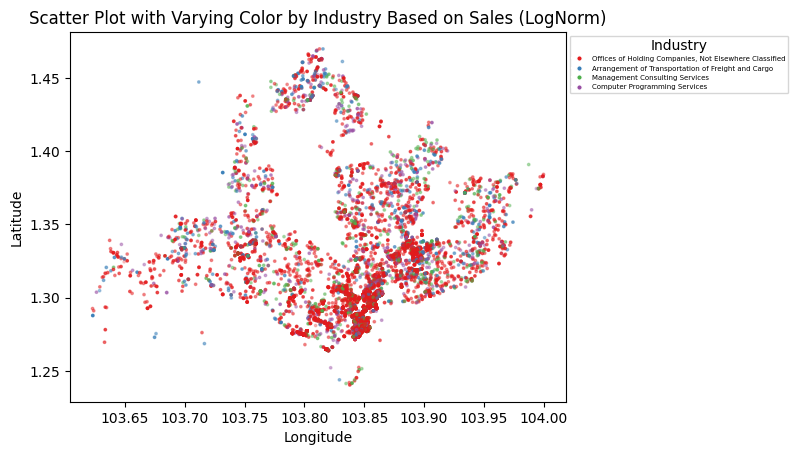

In [ ]:
#Scatter plot of income with reference to company types
filtered_df = df2[df2['SIC Code'].isin([6719, 8742, 7371, 4731])]

constant_color = 'blue'
industry_palette = sns.color_palette('Set1', n_colors=len(filtered_df['Industry'].unique())) # Define a color palette based on unique industries
industry_palette = sns.color_palette('Set1', n_colors=len(filtered_df['Industry'].unique()))
industry_colors = dict(zip(filtered_df['Industry'].unique(), industry_palette)) # Create a dictionary to map Industry to a unique color

scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'], c=filtered_df['Industry'].map(industry_colors), s=3, alpha=norm(filtered_df['Sales (Domestic Ultimate Total USD)'])) # Scatter plot with varying color by Industry and varying alpha based on Sales values

legend_labels = filtered_df['Industry'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry,markerfacecolor=industry_colors[industry], markersize=4) for industry in legend_labels]
plt.legend(handles=legend_handles, title='Industry', prop={'size': 5}, loc='upper left', bbox_to_anchor=(1, 1)) # Add a legend for Industry

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Varying Color by Industry Based on Sales (LogNorm)') # Set labels and title
plt.show()

### Somehow we could not run R code in VS code. Could u help us with it please? 

### read data
sale <- read.csv("./data/catA_train.csv")
head(sale)
dim(sale)
View(sale)
colnames(sale)

library(epiDisplay)

### data management
y <- sale$Sales..Domestic.Ultimate.Total.USD.
sale$latitude <- log10(sale$LATITUDE)
summary(y)
hist(y)
lgy <- log10(y)
summary(lgy)
hist(lgy)
table(is.na(lgy))

country <- sale$Global.Ultimate.Country
table(country)

### description of transformed outcome: log10(y)
install.packages("ggplot")
library(ggplot2)
ggplot(data = sale, aes(x = lgy)) +
  geom_histogram(aes(y = ..density..), colour = "black", fill = "white") +
  geom_density(alpha = .2, fill = "pink")


### description of potential factors
tab1(sale$Entity.Type)
tab1(sale$Is.Domestic.Ultimate)
summary(sale$LATITUDE)
summary(sale$LONGITUDE)
summary(sale$Employees..Single.Site.)
summary(sale$Employees..Domestic.Ultimate.Total.)
summary(sale$Employees..Global.Ultimate.Total.)
tab1(sale$Year.Found)


### univariate analysis

# descriptive statisitcs by group
boxplot(split(lgy, sale$Entity.Type))
summ(lgy, by = sale$Entity.Type)

# t test
t.test(lgy ~ Is.Domestic.Ultimate, data = sale, var.equal = FALSE)

# ANOVA
fit <- aov(lgy ~ Entity.Type, data = sale)
summary(fit)

# homogeneity test of variance
bartlett.test(lgy ~ Entity.Type, data = sale)

# rank sum test
kruskal.test(y ~ Entity.Type, data = sale)
kruskal.test(lgy ~ Entity.Type, data = sale)

# scatter plot
library(car)
library(carData)
scatterplot(lgy ~ sale$latitude, data = sale,
            xlab = "log10(latitude)", ylab = "log10(sales)")

# pearson correlation analysis
cor.test(~latitude + lgy, method = "pearson", data = sale)

# spearman correlation analysis
scatterplot(y ~ sale$Year.Found, data = sale,
            xlab = "year found", ylab = "sales")
cor.test(~ Year.Found + lgy, method = "spearman", data = sale)


### multiple linear regression
fit <- lm(lgy ~ LATITUDE + LONGITUDE +
            as.factor(Entity.Type) + Is.Domestic.Ultimate, data = sale)
summary(fit)

glmfit <- glm(lgy ~ LATITUDE + LONGITUDE + as.factor(Entity.Type) +
                Is.Domestic.Ultimate + Employees..Single.Site.,
              family = gaussian(link = "identity"),	data = sale)
summary(glmfit)

In [ ]:
# Testing----------------------------------------------------------------------

# check for the number of missing values in the dataframe
# print(df3.info())

# Display the updated DataFrame
# print(sic_code_frequency1)

# use of a correlation matrix to observe how variables in our dataset may be affected by others
# numerical_df = df3.select_dtypes(include=['float64', 'int64'])
# Create a correlation matrix
# correlation_matrix = numerical_df.corr()

# Assuming correlation_matrix is your correlation matrix
# correlation_df = pd.DataFrame(correlation_matrix)
# Print or use the correlation DataFrame as needed
# print(correlation_df)


setwd(./data)
data=read.csv(catA_train.csv)

#data cleaning
count_missing_domestic_employee <- sum(is.na(data[,11])); count_missing_domestic_employee
complete_rows <- complete.cases(data[,11])
data <- data[complete_rows, ]
#79

count_missing_global_employee <- sum(is.na(data[,12])); count_missing_global_employee
complete_rows1 <- complete.cases(data[,12])
data <- data[complete_rows1, ]
#2713

count_missing_longitude <- sum(is.na(data[,2])); count_missing_longitude
complete_rows2 <- complete.cases(data[,2])
data <- data[complete_rows2, ]
#112

count_missing_latitude <- sum(is.na(data[,1])); count_missing_latitude
complete_rows3 <- complete.cases(data[,1])
data <- data[complete_rows3, ]
#0

which(`Sales (Domestic Ultimate Total USD)`<0)
data=data[-c(4349,16598),]
#4349 16598

attach(data)

#linear models

##Latitude
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~LATITUDE))
#Adjusted R-squared:  0.0001549 
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~log(LATITUDE)))
#Adjusted R-squared:  0.0001561 

#Longitude
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~LONGITUDE))
#Adjusted R-squared:  7.011e-05 
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~log(LONGITUDE)))
#Adjusted R-squared:  7.022e-05

#Year Found
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Year Found`))
#Adjusted R-squared:  0.05772 
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Year Found`)))
#Adjusted R-squared:  0.05743 

#Entity Type
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Entity Type`))
#Adjusted R-squared:  0.04816 

#Parent Country
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Parent Country`))
#Adjusted R-squared:  0.01129

#Ownership Type
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Ownership Type`))
#Adjusted R-squared:  0.01537

#Employees (Domestic Ultimate Total)
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Employees (Domestic Ultimate Total)`))
#Adjusted R-squared:  0.04039 
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Employees (Domestic Ultimate Total)`)))
#Adjusted R-squared:  0.4817

#Employees (Global Ultimate Total)
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Employees (Global Ultimate Total)`))
#Adjusted R-squared:  0.006512
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Employees (Global Ultimate Total)`)))
#Adjusted R-squared:  0.1948 

#Sales (Global Ultimate Total USD)
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Sales (Global Ultimate Total USD)`))
#Adjusted R-squared:  0.0264 
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Sales (Global Ultimate Total USD)`)))
#Adjusted R-squared:  0.4187

#Global Ultimate Country
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~`Global Ultimate Country`))
#Adjusted R-squared:  0.03951

#Is Domestic Ultimate
domult=ifelse(`Is Domestic Ultimate`==1,"Yes","No")
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~domult))
#Adjusted R-squared:  0.03252 

#Is Global Ultimate
gloult=ifelse(`Is Global Ultimate`==1,"Yes","No")
summary(lm(log(`Sales (Domestic Ultimate Total USD)`)~gloult))
#Adjusted R-squared:  0.05901  

#combined model

#domestic employee
mod=lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Employees (Domestic Ultimate Total)`))
summary(mod)
sr=rstandard(mod)
modde=lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Employees (Domestic Ultimate Total)`),data=data[-which(sr>3|sr<(-3)),])
summary(modde)

#take domestic employee and global sale, having highest adjusted R^2
mod1=lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Employees (Domestic Ultimate Total)`)
     +log(`Sales (Global Ultimate Total USD)`)
     +log(`Employees (Domestic Ultimate Total)`)*log(`Sales (Global Ultimate Total USD)`))
summary(mod1)
sr1=rstandard(mod1)
mod2=lm(log(`Sales (Domestic Ultimate Total USD)`)~log(`Employees (Domestic Ultimate Total)`)
        +log(`Sales (Global Ultimate Total USD)`)
        +log(`Employees (Domestic Ultimate Total)`)*log(`Sales (Global Ultimate Total USD)`)
        ,data=data[-which(sr1>3|sr1<(-3)),])
summary(mod2)

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!